In [1]:
from __future__ import division, print_function
from keras import backend as K
from keras.applications import inception_v3
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, merge
from keras.layers.core import Activation, Dense, Dropout, Lambda
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from random import shuffle
from scipy.misc import imresize
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
DATA_DIR = ""
# IMAGE_DIR = os.path.join(DATA_DIR, "holiday-photos/jpg")
# IMAGE_DIR = os.path.join(DATA_DIR, "train_folder")
IMAGE_DIR = os.path.join(DATA_DIR, "new_test_folder")
    
# image_dir = 'new_test_folder'
file_name = []
dfcols = ['img_name']
df = pd.DataFrame(columns=dfcols)

for img_file in os.listdir(IMAGE_DIR):
    if img_file.find(".jpg") != -1:
        df = df.append(pd.Series([img_file], index=dfcols),
                            ignore_index=True) 
df = df.sort_values("img_name", ascending=True)
df = df.reset_index(drop=True)
df.to_csv('all.csv', encoding='utf-8', index=False)
 
    
group1 = ['0001', '0002', '0003']
group2 = ['0006', '0007', '0008', '0009']
mlabel = ''
all_triples = []
triples = []
for index_1, row_1 in df.iterrows():
    for index_2, row_2 in df.iterrows():
        if index_2 > index_1:
            if row_1['img_name'][2:6] in group1:
                mg_l = '1'
            else:
                mg_l = '2'
            if row_2['img_name'][2:6] in group1:
                mg_r = '1'
            else:
                mg_r = '2'
            mlabel = '0'
            triples = []
            if (row_1['img_name'][0:2] == row_2['img_name'][0:2] and mg_l == '2' and mg_r == '2') :   
                mlabel = '1'
                triples = [row_1['img_name'],row_2['img_name'],mlabel]
#             if (row_1['img_name'][0:2] != row_2['img_name'][0:2] and mg_l == '2' and mg_r == '2') :   
#                 mlabel = '0'
#                 triples = [row_1['img_name'],row_2['img_name'],mlabel]
            if (row_1['img_name'][0:2] == row_2['img_name'][0:2] and mg_l != mg_r ) :   
                mlabel = '0'
                triples = [row_1['img_name'],row_2['img_name'],mlabel]
            if len(triples) != 0 :    
                all_triples.append(triples)

triples_data = all_triples # create_triples(IMAGE_DIR)

print(len(df))
print(len(all_triples))
print(triples_data[0:5])

628
4469
[['010001.jpg', '010006.jpg', '0'], ['010001.jpg', '010007.jpg', '0'], ['010001.jpg', '010008.jpg', '0'], ['010001.jpg', '010009.jpg', '0'], ['010001.jpg', '010010.jpg', '0']]


In [3]:
def load_image_cache(image_cache, image_filename):
    image = plt.imread(os.path.join(IMAGE_DIR, image_filename))
    image = imresize(image, (299, 299))
    image = image.astype("float32")
    image = inception_v3.preprocess_input(image)
    image_cache[image_filename] = image
    
image_cache = {}
num_pairs = len(triples_data)
for i, (image_filename_l, image_filename_r, _) in enumerate(triples_data):
    if i % 1000 == 0:
        print("images from {:d}/{:d} pairs loaded to cache".format(i, num_pairs))
    if image_filename_l not in image_cache:
        load_image_cache(image_cache, image_filename_l)
    if image_filename_r not in image_cache:
        load_image_cache(image_cache, image_filename_r)
print("images from {:d}/{:d} pairs loaded to cache, COMPLETE".format(i, num_pairs))

def pair_generator(triples, image_cache, datagens, batch_size=32):
    while True:
        # shuffle once per batch
        indices = np.random.permutation(np.arange(len(triples)))
        num_batches = len(triples) // batch_size
        for bid in range(num_batches):
            batch_indices = indices[bid * batch_size : (bid + 1) * batch_size]
            batch = [triples[i] for i in batch_indices]
            X1 = np.zeros((batch_size, 299, 299, 3))
            X2 = np.zeros((batch_size, 299, 299, 3))
            Y = np.zeros((batch_size, 2))
            for i, (image_filename_l, image_filename_r, label) in enumerate(batch):
                if datagens is None or len(datagens) == 0:
                    X1[i] = image_cache[image_filename_l]
                    X2[i] = image_cache[image_filename_r]
                else:
                    X1[i] = datagens[0].random_transform(image_cache[image_filename_l])
                    X2[i] = datagens[1].random_transform(image_cache[image_filename_r])
                Y[i] = [1, 0] if label == 0 else [0, 1]
            yield [X1, X2], Y

images from 0/4469 pairs loaded to cache


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


images from 1000/4469 pairs loaded to cache
images from 2000/4469 pairs loaded to cache
images from 3000/4469 pairs loaded to cache
images from 4000/4469 pairs loaded to cache
images from 4468/4469 pairs loaded to cache, COMPLETE


In [4]:
datagen_args = dict(rotation_range=10,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
#                     shear_range = 0.2,
                    zoom_range=0.2)
datagens = [ImageDataGenerator(**datagen_args),
            ImageDataGenerator(**datagen_args)]
pair_gen = pair_generator(triples_data, image_cache, datagens, 32)
[X1, X2], Y = pair_gen.__next__()
print(X1.shape, X2.shape, Y.shape)

# (32, 299, 299, 3) (32, 299, 299, 3) (32, 2)
# Define Model
# The model is composed of two pretrained Inception V3 networks without their last prediction layer, 
# connected to a merge layer that computes element-wise dot product of the two (2048,) sized vectors produced 
# by the Inception V3. This is then fed into a 3 layer fully connected network that produces the similar / not 
# similar prediction.
# The Inception V3 network weights are frozen, and the Fully Connected network weights are loaded from one trained 
# using pre-computed image vectors and allowed to be fine-tuned.
# In [6]:
# distance measure

def absdiff(vecs):
    x, y = vecs
    return K.abs(K.sum(K.stack([x, -y], axis=1), axis=1))

def absdiff_output_shape(shapes):
    return shapes[0]

# BEST_MODEL_FILE = os.path.join(DATA_DIR, "models", "inception-ft-best.h5")
# FINAL_MODEL_FILE = os.path.join(DATA_DIR, "models", "inception-ft-final.h5")

(32, 299, 299, 3) (32, 299, 299, 3) (32, 2)


In [5]:
vecs = [np.random.random((10,)), np.random.random((10,))]
print(vecs[0].shape, vecs[1].shape)
s = absdiff(vecs)
print(s.shape)

# (10,) (10,)
# (10,)
# In [7]:
# load 2 copies of the inception model
# in case of a siamese network, the same instance of the network will be trained,
# but in our case the network is untrainable, so we can have 2 copies
inception_1 = inception_v3.InceptionV3(weights="imagenet", include_top=True)
inception_2 = inception_v3.InceptionV3(weights="imagenet", include_top=True)
# In [8]:
# Here the last two layers are avg_pool and prediction as shown below:
#    avg_pool (None, 8, 8, 2048) (None, 2048)
#    predictions (None, 2048) (None, 1000)
#
# for layer in inception_1.layers:
#     print(layer.name, layer.input_shape, layer.output_shape)
# In [9]:
# freeze weights on the inception network and give each layer a unique name
# since we will combine them into a single network
for layer in inception_1.layers:
    layer.trainable = False
    layer.name = layer.name + "_1"
for layer in inception_2.layers:
    layer.trainable = False
    layer.name = layer.name + "_2"

(10,) (10,)
(10,)


In [10]:
# In [10]:
# outputs of the inception networks, these will be connected to our head FCN
vector_1 = inception_1.get_layer("avg_pool_1").output
vector_2 = inception_2.get_layer("avg_pool_2").output
# In [11]:
# load the pretrained similarity head network. This has been trained to predict similar
# images using image vectors
sim_head = load_model(os.path.join(DATA_DIR, "models", "A_A_inceptionv3-l1-final_10.h5"))
for layer in sim_head.layers:
    print(layer.name, layer.input_shape, layer.output_shape)

input_5 (None, 2048) (None, 2048)
input_6 (None, 2048) (None, 2048)
lambda_2 [(None, 2048), (None, 2048)] (None, 2048)
dense_7 (None, 2048) (None, 512)
dropout_5 (None, 512) (None, 512)
activation_7 (None, 512) (None, 512)
dense_8 (None, 512) (None, 128)
dropout_6 (None, 128) (None, 128)
activation_8 (None, 128) (None, 128)
dense_9 (None, 128) (None, 2)
activation_9 (None, 2) (None, 2)


In [11]:
# In [12]:
# attach output of the inception networks to the similarity head
# output is a prediction tensor
prediction = sim_head([vector_1, vector_2])
# In [13]:
# declare a model that takes image inputs on its truncated Inception subnetworks
# and returns the prediction as the output. Inputs are Input(shape=(299, 299, 3))
model = Model(inputs=[inception_1.input, inception_2.input], outputs=prediction)

model.compile(optimizer="Nadam", loss="categorical_crossentropy", metrics=["accuracy"])
# Train Network
# In [14]:
BATCH_SIZE = 32
NUM_EPOCHS = 10
BEST_MODEL_FILE = os.path.join(DATA_DIR, "models", "A_A_inceptionv3-l1-ft-best_10_v2.h5")
FINAL_MODEL_FILE = os.path.join(DATA_DIR, "models", "A_A_inceptionv3-l1-ft-final_10_v2.h5")
# In [15]:
triples_data_trainval, triples_data_test = train_test_split(triples_data, train_size=0.8)
triples_data_train, triples_data_val = train_test_split(triples_data_trainval, train_size=0.9)
print(len(triples_data_train), len(triples_data_val), len(triples_data_test))
# 3217 358 894

3217 358 894


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Epoch 1/10
100/100 [==============================] - 363s 4s/step - loss: 5.7553e-05 - acc: 1.0000 - val_loss: 6.9935e-07 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 353s 4s/step - loss: 2.6492e-06 - acc: 1.0000 - val_loss: 3.9522e-07 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 352s 4s/step - loss: 1.9945e-07 - acc: 1.0000 - val_loss: 3.5407e-07 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 352s 4s/step - loss: 3.3647e-06 - acc: 1.0000 - val_loss: 2.3893e-07 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 352s 4s/step - loss: 1.8042e-06 - acc: 1.0000 - val_loss: 1.6848e-07 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 352s 4s/step - loss: 1.5161e-06 - acc: 1.0000 - val_loss: 1.5934e-07 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 352s 4s/step - loss: 1.2526e-07 - acc: 1.0000 - val_loss: 1.5511e-07 - val_acc: 1.0000
Epoch 8/10
10

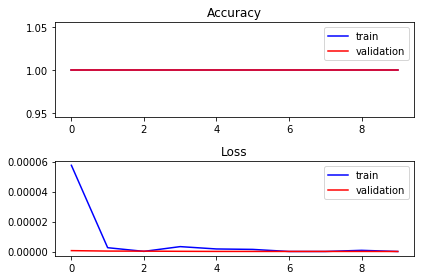

In [12]:
# In [16]:
datagen_args = dict(rotation_range=10,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
#                     shear_range = 0.2, ###
                    zoom_range=0.2)
datagens = [ImageDataGenerator(**datagen_args),
            ImageDataGenerator(**datagen_args)]
train_pair_gen = pair_generator(triples_data_train, image_cache, datagens, BATCH_SIZE)
val_pair_gen = pair_generator(triples_data_val, image_cache, None, BATCH_SIZE)
# In [17]:
num_train_steps = len(triples_data_train) // BATCH_SIZE
num_val_steps = len(triples_data_val) // BATCH_SIZE
# In [18]:
checkpoint = ModelCheckpoint(filepath=BEST_MODEL_FILE, save_best_only=True)
history = model.fit_generator(train_pair_gen, 
                             steps_per_epoch=num_train_steps,
                             epochs=NUM_EPOCHS,
                             validation_data=val_pair_gen,
                             validation_steps=num_val_steps,
                             callbacks=[checkpoint])

plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="blue", label="train")
plt.plot(history.history["val_acc"], color="red", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="blue", label="train")
plt.plot(history.history["val_loss"], color="red", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# In [20]:
model.save(FINAL_MODEL_FILE, overwrite=True)
# Predictions
# In [21]:


In [13]:
def evaluate_model(model):
    ytest, ytest_ = [], []
    test_pair_gen = pair_generator(triples_data_test, image_cache, None, BATCH_SIZE)
    num_test_steps = len(triples_data_test) // BATCH_SIZE
    curr_test_steps = 0
    for [X1test, X2test], Ytest in test_pair_gen:
        if curr_test_steps > num_test_steps:
            break
        Ytest_ = model.predict([X1test, X2test])
        ytest.extend(np.argmax(Ytest, axis=1).tolist())
        ytest_.extend(np.argmax(Ytest_, axis=1).tolist())
        curr_test_steps += 1
    acc = accuracy_score(ytest, ytest_)
    cm = confusion_matrix(ytest, ytest_)
    return acc, cm

In [14]:
print("==== Evaluation Results: final model on test set ====")
final_model = load_model(FINAL_MODEL_FILE)
acc, cm = evaluate_model(final_model)
print("Accuracy Score: {:.3f}".format(acc))
print("Confusion Matrix")
print(cm)


==== Evaluation Results: final model on test set ====
Accuracy Score: 1.000
Confusion Matrix
[[896]]


In [15]:
print("==== Evaluation Results: best model on test set ====")
best_model = load_model(BEST_MODEL_FILE)
acc, cm = evaluate_model(best_model)
print("Accuracy Score: {:.3f}".format(acc))
print("Confusion Matrix")
print(cm)


==== Evaluation Results: best model on test set ====
Accuracy Score: 1.000
Confusion Matrix
[[896]]


In [11]:
image = plt.imread(os.path.join(IMAGE_DIR, '100001.jpg'))
image = imresize(image, (299, 299))
image = image.astype("float32")
image = inception_v3.preprocess_input(image)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


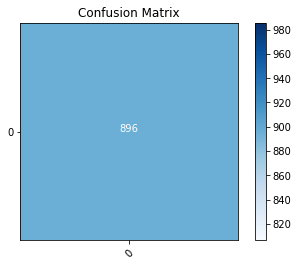

In [16]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plot_confusion_matrix(cm, range(0, 1))

In [17]:
ytest, ytest_ = [], []
test_pair_gen = pair_generator(triples_data_test, image_cache, None, BATCH_SIZE)
num_test_steps = len(triples_data_test) // BATCH_SIZE
curr_test_steps = 0
test_pair_gen

<generator object pair_generator at 0x7f55bd5061a8>

In [18]:
ytest, ytest_ = [], []
i = 0
for [X1test, X2test], Ytest in test_pair_gen:
    i += 1
    print(X1test)
    if curr_test_steps > num_test_steps:
        break
    Ytest_ = best_model.predict([X1test, X2test])
    ytest.extend(np.argmax(Ytest, axis=1).tolist())
    ytest_.extend(np.argmax(Ytest_, axis=1).tolist())
    curr_test_steps += 1
    print(ytest)
    print(ytest_)
    break

acc = accuracy_score(ytest, ytest_)
cm = confusion_matrix(ytest, ytest_)

print("Accuracy Score: {:.3f}".format(acc))
print("Confusion Matrix")
print(cm)

[[[[-0.23921567 -0.38823527 -0.35686272]
   [-0.24705881 -0.39607841 -0.36470586]
   [-0.24705881 -0.39607841 -0.35686272]
   ...
   [-0.27058822 -0.39607841 -0.41960782]
   [-0.3098039  -0.42745095 -0.45098037]
   [-0.48235291 -0.60000002 -0.62352943]]

  [[-0.25490195 -0.41176468 -0.33333331]
   [-0.24705881 -0.40392154 -0.33333331]
   [-0.24705881 -0.40392154 -0.33333331]
   ...
   [-0.25490195 -0.372549   -0.39607841]
   [-0.29411763 -0.41176468 -0.43529409]
   [-0.372549   -0.49019605 -0.51372552]]

  [[-0.26274508 -0.41176468 -0.34117645]
   [-0.25490195 -0.41176468 -0.34117645]
   [-0.23921567 -0.39607841 -0.33333331]
   ...
   [-0.2235294  -0.34901959 -0.372549  ]
   [-0.25490195 -0.372549   -0.39607841]
   [-0.3098039  -0.42745095 -0.45098037]]

  ...

  [[-0.3098039  -0.45098037 -0.49803919]
   [-0.30196077 -0.45098037 -0.49019605]
   [-0.30196077 -0.44313723 -0.48235291]
   ...
   [ 0.15294123  0.15294123  0.04313731]
   [ 0.1686275   0.17647064  0.06666672]
   [ 0.20000005 

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Accuracy Score: 1.000
Confusion Matrix
[[32]]
